# ipymario: from a tweet to anywidget

In this notebook, we'll take some fun code from [a tweet](https://x.com/mbostock/status/1765222176641437859) bring it into Jupyter using **anywidget**.

Our goal is to illustrate how to _think_ about building Python APIs on top of existing front-end functionality. 
This process is essential when connecting a JavaScript library to Python.

We'll reinforce much of what we learned from the previous section and cover new concepts like:

- Custom messages
- Sending binary data
- Project organization

This will help you understand the process of exposing JavaScript functionality through Python, creating a fun and interactive widget along the way.

## The tweet

Ok, what the heck is this?

```javascript
c=new AudioContext(),g=c.createGain(),o=c.createOscillator(),G=g.gain,
of=o.frequency,g.connect(c.destination),G.value=0.1,G.linearRampToValueAtTime(0,1),
o.connect(g),o.type="square",of.setValueAtTime(988,0),of.setValueAtTime(1319,0.08),
o.start(),o.stop(1)
```

When I first saw this code a couple of things stood out to me. First it was authored by Mike Bostock, the creator of Observable and D3, and second it makes use of [`AudioContext`](https://developer.mozilla.org/en-US/docs/Web/API/AudioContext), which is a part of the [Web Audio API](https://developer.mozilla.org/en-US/docs/Web/API/Web_Audio_API). The Web Audio API allows creating and controlling audio in web applications and is supported by all modern browsers.

I generally wouldn't recommend copying and pasting code into the browser (or terminal) like this, but I let my interest get the best of me and ran the code...

~ **mario chime** ~

Ah, it makes a fun chime noise! We can use that.


[Web APIs](https://developer.mozilla.org/en-US/docs/Web/API) like the Web Audio API are cool because they are 
built right into the browser and allow accessing various system features without extra software. 

As such, this snippet is a nice demo because we don't need to install anything or
learn some third-party API. We can build an example from scratch.

I took the time to fix up this code so that it is more readable:

```javascript
/** Makes a Mario chime sound using web `AudioContext` API. */
function chime() {
  const c = new AudioContext();
  const g = c.createGain();
  const o = c.createOscillator();
  g.connect(c.destination);
  g.gain.value = 0.1;
  g.gain.linearRampToValueAtTime(0, 1);
  o.connect(g);
  o.type = "square";
  o.frequency.setValueAtTime(988, 0);
  o.frequency.setValueAtTime(1319, 0.08);
  o.start();
  o.stop(1);
}
```

Now we can get a better sense of what is going on.

## Bringing it in a notebook

To get started, let's take this JavaScript function and bring it into a widget `_esm`. 
Our goal initially is to "just get it working."

We can start by import anywidget and traitlets and build up our demo like before.

In [1]:
import anywidget
import traitlets

#### Exercise 1
Create a widget that chimes when it is displayed.

In [6]:
# Exercise 1

class Widget(anywidget.AnyWidget):
    _esm = """
    function chime() {
  const c = new AudioContext();
  const g = c.createGain();
  const o = c.createOscillator();
  g.connect(c.destination);
  g.gain.value = 0.1;
  g.gain.linearRampToValueAtTime(0, 1);
  o.connect(g);
  o.type = "square";
  o.frequency.setValueAtTime(988, 0);
  o.frequency.setValueAtTime(1319, 0.08);
  o.start();
  o.stop(1);
}

function render() {
        chime();
    }
    export default { render };
    """

Widget()

Widget()

In [2]:
# %load ./answers/03-01.py
# Exercise 1 Solution

class Widget(anywidget.AnyWidget):
    _esm = """
    function chime() {
      const c = new AudioContext();
      const g = c.createGain();
      const o = c.createOscillator();
      g.connect(c.destination);
      g.gain.value = 0.1;
      g.gain.linearRampToValueAtTime(0, 1);
      o.connect(g);
      o.type = "square";
      o.frequency.setValueAtTime(988, 0);
      o.frequency.setValueAtTime(1319, 0.08);
      o.start();
      o.stop(1);
    }
    function render() {
    const button = document.createElement("button");
        chime();
    }
    export default { render };
    """

Widget()

## Create button to trigger the chime

Right now our widget is pretty simple. It just chimes anytime we display the widget, but there 
currently isn't a way to trigger the `chime` from Python or a user interaction. 

Let's change that!

#### Exercise 2
Extend the answer from  **Exercise 1** with the following features:

- Create a `button` element and _append_ it to the output cell
- Set the `button` text to "It's a me, Mario!"
- Add a "click" event listener to the button that calls `chime` every time the button is clicked

In [ ]:
# Exercise 2


In [ ]:
%load ./answers/03-02.py

## Parameterize the chime with traitlets

Looking closer at the `chime` function, there are a few hard-coded values that we can move up as parameters. 
Specifically, we can expose the:

- `duration` (how long the sound lasts in total)
- `tone1` (the frequency of the first tone)
- `tone2` (the frequency of the second tone)

to the Python side.

First, we'll modify the `chime` function to accept these two parameters:

```javascript
function chime({ duration, tone1, tone2 }) { // <---- NEW!
  const c = new AudioContext();
  const g = c.createGain();
  const o = c.createOscillator();
  g.connect(c.destination);
  g.gain.value = 0.1;
  g.gain.linearRampToValueAtTime(0, duration); // <---- NEW!
  o.connect(g);
  o.type = "square";
  o.frequency.setValueAtTime(tone1, 0);
  o.frequency.setValueAtTime(tone2, 0.08); // <---- NEW!
  o.start();
  o.stop(duration); // <---- NEW!
}
```

We can then update our original widget code to use this updated function, but
but we still have hard-coded the values still on the JavaScript side.

#### Exercise 3 
Using your knowledge about traitlets, modify the snippet to turn `duration`, `tone1`, 
and `tone2` within the button click handler into pieces of shared state.

In [13]:
# Exercise 3

class Widget(anywidget.AnyWidget):
    _esm = """
    function chime({ duration, tone1, tone2 }) { // <---- NEW!
      const c = new AudioContext();
      const g = c.createGain();
      const o = c.createOscillator();
      g.connect(c.destination);
      g.gain.value = 0.1;
      g.gain.linearRampToValueAtTime(0, duration); // <---- NEW!
      o.connect(g);
      o.type = "square";
      o.frequency.setValueAtTime(tone1, 0); // <---- NEW!
      o.frequency.setValueAtTime(tone2, 0.08); // <---- NEW!
      o.start();
      o.stop(duration); // <---- NEW!
    }
    function render({ model, el }) {
      const btn = document.createElement("button");
      btn.innerText = "It's me Mario!";
      btn.addEventListener("click", () => {
        chime({ duration: 1.0, tone1: 988, tone2: 1319 }); // <---- NEW!
      });
      el.appendChild(btn);
    }
    export default { render };
    """
    duration = traitlets.Float(1.0).tag(sync=True);
    tone1 = traitlets.Int(200).tag(sync=True);
    tone2 = traitlets.Int(100).tag(sync=True);


widget = Widget()
widget

Widget()

Once we've set the traitlets, we can now adjust the `duration`, `tone1`, and `tone2` from other notebook cells.

In [9]:
widget.duration = 2 # long duration

In [10]:
widget.tone1 = 494 # 1/2 original

In [11]:
widget.tone2 = 659 # 1/2 original

In [8]:
# %load ./answers/03-03.py
# Exercise 3 Solution

class Widget(anywidget.AnyWidget):
    _esm = """
    function chime({ duration, tone1, tone2 }) { // <---- NEW!
      const c = new AudioContext();
      const g = c.createGain();
      const o = c.createOscillator();
      g.connect(c.destination);
      g.gain.value = 0.1;
      g.gain.linearRampToValueAtTime(0, duration); // <---- NEW!
      o.connect(g);
      o.type = "square";
      o.frequency.setValueAtTime(tone1, 0); // <---- NEW!
      o.frequency.setValueAtTime(tone2, 0.08); // <---- NEW!
      o.start();
      o.stop(duration); // <---- NEW!
    }
    function render({ model, el }) {
      const btn = document.createElement("button");
      btn.innerText = "It's me Mario!";
      btn.addEventListener("click", () => {
        chime({ duration: model.get("duration"), tone1: model.get("tone1"), tone2: model.get("tone2") }); // <---- NEW!
      });
      el.appendChild(btn);
    }
    export default { render };
    """
    duration = traitlets.Float(1.0).tag(sync=True)
                             # ^ provide a default value
    tone1 = traitlets.Int(988).tag(sync=True)
                        # ^ provide a default value
    tone2 = traitlets.Int(1319).tag(sync=True)
                        # ^ provide a default value

widget = Widget()
widget



## "Click" the button from Python

Currently, we can only trigger `chime` by manually pressing the button. It would be useful to programmatically "click" the button from Python:

```python
widget.click() # triggers the sound
```

To achieve this, we use the `AnyWidget.send` API. Unlike traitlets, send allows communication between the front end and back end without syncing state. Since a click event isn't state we want to store, `send` is appropriate.

On the Python side, we can emit messages with `AnyWidget.send` and then on the front-end side we need to be ready to listen to those messages. We can subscribe to all messages send to the front-end model with
"msg:custom" event name.

### Logger widget

The most simple example of a widget using `send` is one that forwards messages to the browser `console`.

In [14]:
class Console(anywidget.AnyWidget):
    _esm = """
    function render({ model }) {
      model.on("msg:custom", (msg) => {
        console.log(msg);
      })
    }
    export default { render }
    """

console = Console()
console # display so we run `render`

Console()

In [17]:
# open the browser console and run the next cell
console.send("hello")

In [18]:
# but we can kind of send anything we want.... 
console.send({ "foo": "bar" }) 

`send` is a fairly low-level API, so it's not generally recommended to have end users call send directly. Instead, we can implement a function on `Console` that wraps send in a controlled manner:

In [19]:
class Console(anywidget.AnyWidget):
    _esm = """
    function render({ model }) {
      model.on("msg:custom", (msg) => {
        if (msg?.kind === "message") {
          console.log(msg.data);
         }
      });
    }
    export default { render }
    """

    def log(self, message: str):
        # we only receive messages of kind=="message" on the front end, 
        # ignore everything else
        self.send({ "kind": "message", "data": message })

console = Console()
console # display so we run `render`

Console()

In [20]:
console.log("woohoooo!")

This is much clearer and hides the fact that we are using send under the hood.

### Implementing `.click()`

Let's go back to our mario example and implement the goal:

```python
widget.click() # clicks the button
```

#### Exercise 4
Implement `Widget.click()` using the `send` API.

> Hint: HTMLElement's like our `btn` have a [`.click()` method](https://developer.mozilla.org/en-US/docs/Web/API/HTMLElement/click) to synthetically trigger a click event from JavaScript.

In [28]:
# Example 4

class Widget(anywidget.AnyWidget):
    _esm = """
    function chime({ duration, tone1, tone2 }) {
      const c = new AudioContext();
      const g = c.createGain();
      const o = c.createOscillator();
      g.connect(c.destination);
      g.gain.value = 0.1;
      g.gain.linearRampToValueAtTime(0, duration);
      o.connect(g);
      o.type = "square";
      o.frequency.setValueAtTime(tone1, 0);
      o.frequency.setValueAtTime(tone2, 0.08);
      o.start();
      o.stop(duration);
    }
    function render({ model, el }) {
      const btn = document.createElement("button");
      btn.innerText = "It's me Mario!";
      btn.addEventListener("click", () => {
        chime({ duration: model.get("duration"), tone1: model.get("tone1"), tone2: model.get("tone2") });
      });
       model.on("msg:custom", (msg) => {
        if (msg?.kind === "click") {
          btn.click();
         }
      });
      el.appendChild(btn);
    }
    export default { render };
    """
    duration = traitlets.Float(1.0).tag(sync=True)
    tone1 = traitlets.Int(988).tag(sync=True)
    tone2 = traitlets.Int(1319).tag(sync=True)

    def click(self):
        self.send({"kind":"click"})
        

widget = Widget()
widget

Widget()

In [30]:
# Running this cell should trigger and a noise
widget.click()

In [23]:
# %load ./answers/03-04.py
# Example 4 Solution

class Widget(anywidget.AnyWidget):
    _esm = """
    function chime({ duration, tone1, tone2 }) {
      const c = new AudioContext();
      const g = c.createGain();
      const o = c.createOscillator();
      g.connect(c.destination);
      g.gain.value = 0.1;
      g.gain.linearRampToValueAtTime(0, duration);
      o.connect(g);
      o.type = "square";
      o.frequency.setValueAtTime(tone1, 0);
      o.frequency.setValueAtTime(tone2, 0.08);
      o.start();
      o.stop(duration);
    }
    function render({ model, el }) {
      const btn = document.createElement("button");
      btn.innerText = "It's me Mario!";
      btn.addEventListener("click", () => {
        chime({ duration: model.get("duration"), tone1: model.get("tone1"), tone2: model.get("tone2") });
      });
      model.on("msg:custom", (msg) => {
        if (msg?.kind === "click") btn.click();
      });
      el.appendChild(btn);
    }
    export default { render };
    """
    duration = traitlets.Float(1.0).tag(sync=True)
    tone1 = traitlets.Int(988).tag(sync=True)
    tone2 = traitlets.Int(1319).tag(sync=True)

    def click(self):
        self.send({ "kind": "click" })

widget = Widget()
widget



## Code reorganization and anywidget HMR

Our widget is coming together, but this JavaScript string is getting unwieldy and hard to read. With **anywidget**, we can transition from inline strings to separate files as the project grows.

Let's start by moving the JavaScript code to a separate file called `index.js` in this directory. 

In [ ]:
# copy esm to a file called `index.js`

Open `index.js` in JupyterLab:

- Open `index.js` in a separate pane.
- Drag it to the right of the notebook.
- You should have two panes, left and right, for editing code.

We can then point to that new file from our `Widget` class in the notebook. Instead of providing the file contents as a string, we can use a file path for `_esm`:

In [33]:
%env ANYWIDGET_HMR=1

env: ANYWIDGET_HMR=1


In [34]:
class Widget(anywidget.AnyWidget):
    _esm = "index.js"
    duration = traitlets.Float(1.0).tag(sync=True)
    tone1 = traitlets.Int(988).tag(sync=True)
    tone2 = traitlets.Int(1319).tag(sync=True)

    def click(self):
        self.send({ "kind": "click" })

widget = Widget()
widget

Widget()

That's much nicer. The JavaScript code has syntax highlighting and in a different editor, like VS Code, it also would have more type information and auto complete.

In [ ]:
widget.click()

## Creating the brick (with numpy!)

A common misconception about widgets is that they only support 
JSON-serializable data. However, the Jupyter Widgets Messaging 
Protocol also supports custom binary data. Both anywidget and 
ipywidgets can automatically handle custom binary data within 
JSON-serializable structures (e.g., `dict`, `list`). 

This feature allows you to pass binary data to and from the front 
end efficiently,  without needing to convert it to JSON or base64 encode it.

Let's create a mario brick with `numpy` and send the underlying binary data directly
to the front end using _binary serialization_.

We can start by making the brick data:

In [35]:
# fmt: off
box = [
    ['O', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'X', 'O'],
    ['X', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', 'O'],
    ['X', ' ', 'O', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', 'O', ' ', 'O'],
    ['X', ' ', ' ', ' ', ' ', 'X', 'X', 'X', 'X', 'X', ' ', ' ', ' ', ' ', ' ', 'O'],
    ['X', ' ', ' ', ' ', 'X', 'X', 'O', 'O', 'O', 'X', 'X', ' ', ' ', ' ', ' ', 'O'],
    ['X', ' ', ' ', ' ', 'X', 'X', 'O', ' ', ' ', 'X', 'X', 'O', ' ', ' ', ' ', 'O'],
    ['X', ' ', ' ', ' ', 'X', 'X', 'O', ' ', ' ', 'X', 'X', 'O', ' ', ' ', ' ', 'O'],
    ['X', ' ', ' ', ' ', ' ', 'O', 'O', ' ', 'X', 'X', 'X', 'O', ' ', ' ', ' ', 'O'],
    ['X', ' ', ' ', ' ', ' ', ' ', ' ', 'X', 'X', 'O', 'O', 'O', ' ', ' ', ' ', 'O'],
    ['X', ' ', ' ', ' ', ' ', ' ', ' ', 'X', 'X', 'O', ' ', ' ', ' ', ' ', ' ', 'O'],
    ['X', ' ', ' ', ' ', ' ', ' ', ' ', ' ', 'O', 'O', ' ', ' ', ' ', ' ', ' ', 'O'],
    ['X', ' ', ' ', ' ', ' ', ' ', ' ', 'X', 'X', ' ', ' ', ' ', ' ', ' ', ' ', 'O'],
    ['X', ' ', ' ', ' ', ' ', ' ', ' ', 'X', 'X', 'O', ' ', ' ', ' ', ' ', ' ', 'O'],
    ['X', ' ', 'O', ' ', ' ', ' ', ' ', ' ', 'O', 'O', ' ', ' ', ' ', 'O', ' ', 'O'],
    ['X', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', 'O'],
    ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'],
]
# fmt: on

If you squink close enough you can kind of make out a question mark. We represent the brick data this way because it is easy to edit, but first we need to convert it into the correct RGBA array.

We can do this by defining a colormapping of our symbols (`X`, ` `, `O`) to the RGBA colors they correspond to.

In [36]:
colors = {
    "O": [0, 0, 0, 255],
    "X": [247, 82, 0, 255],
    " ": [247, 186, 119, 255],
}

Then using `numpy` we can get this nested array as a nice (16, 16, 4) RGBA array.

In [37]:
import numpy as np

np_box = np.array([[colors[c] for c in row] for row in box], dtype=np.uint8)
np_box.shape

(16, 16, 4)

We can make sure we did everything correctly by plotting the brick quickly with matplotlib

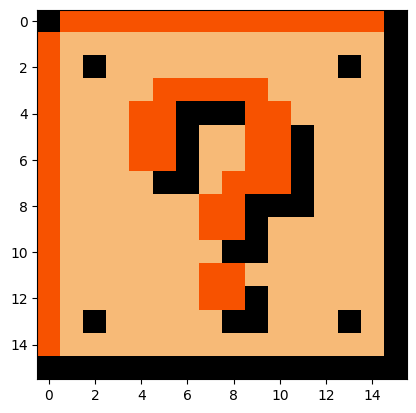

In [38]:
import matplotlib.pyplot as plt

plt.imshow(np_box)

hooray!

## Send brick data to the front end (binary data transfer)

We can access the underlying binary data for our `uint8` numpy array using `np_box.tobytes()`, and send it to 
the front end with traitlets. On the front-end we can log out the data with:

```javascript
function render({ model }) {
    console.log(model.get("_bytes")
}
```

#### Exercise 5
Send binary data to the front end

- Uncomment the `_bytes` traitlet
- Modify the `index.js` to `console.log` the value that you get back


In [44]:
# Exercise 5 

class Widget(anywidget.AnyWidget):
    _esm = "index.js"
    duration = traitlets.Float(1.0).tag(sync=True)
    tone1 = traitlets.Int(988).tag(sync=True)
    tone2 = traitlets.Int(1319).tag(sync=True)
    size = traitlets.Int(30).tag(sync=True)
    
    # our new traitlet
    _bytes = traitlets.Bytes(np_box.tobytes()).tag(sync=True)

    def click(self):
        self.send({ "kind": "click" })

widget = Widget()
widget

Widget()

For the remaining answers we only provde the JS code because the Python should be minimal. 

In [ ]:
%load ./answers/03-05.js

## Drawing the data

Now that we have the binary data in the front-end, we can render it 
using the [Web Canvas API](https://developer.mozilla.org/en-US/docs/Web/API/Canvas_API).

This part of the tutorial has the most moving parts, so take your time with it. It's okay to skip if you prefer.

First, we'll change our `button` element to a `canvas`. We want to replace our button and all its functionality with a different element. This involves modifying just a few lines of code. 

Step 1. Replace button with canvas

```javascript
function render({ model, el }) {
  const canvas = document.createElement("canvas");
  canvas.addEventListener("click", () => {
    chime({ duration: model.get("duration"), gain: model.get("gain") });
  });
  model.on("msg:custom", (msg) => {
    if (msg?.kind === "click") canvas.click();
  });
  el.appendChild(canvas);
}
```



Step 2. Use the Canvas API to render it.

```javascript
function render({ model, el }) {
  const canvas = document.createElement("canvas");

  // NEW!
  canvas.width = 16;
  canvas.height = 16;
  canvas.style.width = "30px"
  canvas.style.height = "30px";

  // NEW!
  const bytes = new Uint8ClampedArray(
    model.get("_bytes").buffer,
  );
  const imgData = new ImageData(bytes, 16, 16);
  const ctx = canvas.getContext("2d");
  ctx.putImageData(imgData, 0, 0);

  // OLD!
  canvas.addEventListener("click", () => {
    chime({ duration: model.get("duration"), gain: model.get("gain") });
  });
  model.on("msg:custom", (msg) => {
    if (msg?.kind === "click") canvas.click();
  });
  el.appendChild(canvas);
}
```

This is quite a bit of code to digest and not something you need to fully understand today. 

#### Exercise 6
Apply the above changes to `index.js`. In the end, you should see a brick rendered in the output. You should be able to click the brick and hear the chime, just like the `button`.

In [43]:
# Exercise 6

class Widget(anywidget.AnyWidget):
    _esm = "index.js"
    duration = traitlets.Float(1.0).tag(sync=True)
    tone1 = traitlets.Int(988).tag(sync=True)
    tone2 = traitlets.Int(1319).tag(sync=True)
    _bytes = traitlets.Bytes(np_box.tobytes()).tag(sync=True)

    def click(self):
        self.send({ "kind": "click" })

widget = Widget()
widget

Widget()

In [ ]:
%load ./answers/03-06.js

## Animate the brick jumping

To animate the brick jumping, we'll use CSS animations. While we won't go into the details for the sake of time, this demonstrates that it's possible to create complex interactions.

#### Exercise 7 (skipped for the tutorial)

**Define the CSS for the animation**: We'll add padding and set the `image-rendering` to pixelated to ensure the image stays pixelated. We'll also define a keyframe animation called `ipymario-bounce` that moves the brick up and down. 

Put the following in a new file called `styles.css`:

```css
.ipymario > canvas {
    padding: 12px;
    animation-fill-mode: both;
    image-rendering: pixelated; /* Ensures the image stays pixelated */
}

@keyframes ipymario-bounce {
  0%, 100% { transform: translateY(0); }
  50% { transform: translateY(-12px); }
}
```

**Add the animation to the canvas**: When the canvas is clicked, we'll trigger the chime and, if animation is enabled, temporarily remove any existing animation before applying the ipymario-bounce animation.

```javascript

  el.classList.add("ipymario");
  
  canvas.addEventListener("click", () => {
    chime({  duration: model.get("duration"),  gain: model.get("gain") });
    // Reset the animation
    canvas.style.animation = "none";
    setTimeout(() => {
      canvas.style.animation = "ipymario-bounce 0.2s";
    }, 10);
  });

```

In [45]:
# Exercise 7

class Widget(anywidget.AnyWidget):
    _esm = "./answers/03-07.js"
    _css = "./answers/03-07.css"
    duration = traitlets.Float(1.0).tag(sync=True)
    tone1 = traitlets.Int(988).tag(sync=True)
    tone2 = traitlets.Int(1319).tag(sync=True)
    _bytes = traitlets.Bytes(np_box.tobytes()).tag(sync=True)

    def click(self):
        self.send({ "kind": "click" })

widget = Widget()
widget

Widget()

In [ ]:
%load ./answers/03-07.js

In [ ]:
%load ./answers/03-07.css

## Creating a UI with `ipywidgets`

With our completed widget, we can connect it with other `ipywidgets` to control the behavior of the various traitlets that have been included. Briefly, we will create a UI for the widget and display it.


In [ ]:
from ipywidgets import Button, IntSlider, VBox, link 

# our ipymario
widget = Widget() 

# our ui
jump = Button(description="Jump!")
reset = Button(description="Reset")
tone1 = IntSlider(min=800, max=1000)
tone2 = IntSlider(min=600, max=1319)

def click_brick(_):
    widget.click()
    
def reset_to_defaults(_):
    tone1.value = 988
    tone2.value = 1319

link((tone1, "value"), (widget, "tone1"))
link((tone2, "value"), (widget, "tone2"))
jump.on_click(click_brick)
reset.on_click(reset_to_defaults)

VBox([widget, jump, tone1, tone2, reset])

#### Exercise 8

Add an additional UI element above to control another aspect of state. Some ideas:

- A button that sets a random value for the tone sliders.
- A slider for the duration traitlet.
